In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 43766458.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# part a

In [12]:
# Keep only airplane (class 0) and automobile (class 1) samples
selected_classes = [0, 1]
selected_train_indices = [i for i, label in enumerate(train_dataset.targets) if label in selected_classes]
selected_test_indices = [i for i, label in enumerate(test_dataset.targets) if label in selected_classes]

train_sampler = torch.utils.data.SubsetRandomSampler(selected_train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(selected_test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, sampler=test_sampler)

In [ ]:
# Define the pre-trained model (ResNet50)
pretrained_model = models.resnet50(pretrained=True)
pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


In [ ]:
# Freeze the layers of the pre-trained model
for param in pretrained_model.parameters():
    param.requires_grad = False

# Add a new fully connected layer for two-class classification
model = nn.Sequential(
    pretrained_model,
    nn.Flatten(),
    nn.Linear(2048, 2)  # Two classes: airplane and automobile
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
train_losses = []
train_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10, Loss: 0.2106, Accuracy: 0.9212
Epoch 2/10, Loss: 0.1455, Accuracy: 0.9432
Epoch 3/10, Loss: 0.1335, Accuracy: 0.9486
Epoch 4/10, Loss: 0.1270, Accuracy: 0.9509
Epoch 5/10, Loss: 0.1210, Accuracy: 0.9545
Epoch 6/10, Loss: 0.1174, Accuracy: 0.9533
Epoch 7/10, Loss: 0.1116, Accuracy: 0.9574
Epoch 8/10, Loss: 0.1214, Accuracy: 0.9532
Epoch 9/10, Loss: 0.1139, Accuracy: 0.9552
Epoch 10/10, Loss: 0.1069, Accuracy: 0.9588


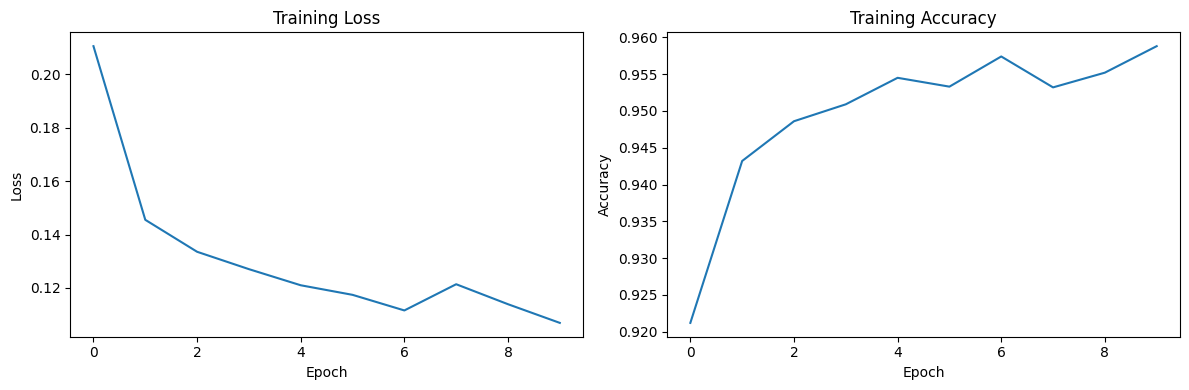

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9655


# part b)

In [5]:
# Define a custom dataset for triplets
class TripletDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        anchor, anchor_label = self.dataset[index]

        # Select positive sample from the same class
        positive_index = index
        while positive_index == index:
            positive_index = torch.randint(len(self.dataset), size=(1,)).item()

        positive, positive_label = self.dataset[positive_index]

        # Select negative sample from a different class
        negative_index = index
        while negative_index == index or self.dataset[negative_index][1] == anchor_label:
            negative_index = torch.randint(len(self.dataset), size=(1,)).item()

        negative, _ = self.dataset[negative_index]

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative, anchor_label

# Triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()


In [6]:
train_loader2 = DataLoader(TripletDataset(train_dataset), batch_size=32, sampler=train_sampler)

In [7]:
# Define a custom ResNet model without the fully connected layer
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        return self.resnet(x)

# Initialize the model, criterion, and optimizer for triplet loss training
triplet_model = CustomResNet().to(device)
triplet_criterion = TripletLoss(margin=1.0)
triplet_optimizer = optim.Adam(triplet_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [8]:
# Train the model with triplet loss
num_triplet_epochs = 5
for epoch in range(num_triplet_epochs):
    triplet_model.train()

    for batch in train_loader2:
        anchor, positive, negative, anchor_label = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        triplet_optimizer.zero_grad()
        loss_triplet = triplet_criterion(triplet_model(anchor), triplet_model(positive), triplet_model(negative))
        loss_triplet.backward()
        triplet_optimizer.step()

    print(f"Epoch {epoch+1}/{num_triplet_epochs}, Triplet Loss: {loss_triplet.item()}")


Epoch 1/5, Triplet Loss: 1.0478734970092773
Epoch 2/5, Triplet Loss: 0.9686228036880493
Epoch 3/5, Triplet Loss: 0.5346509218215942
Epoch 4/5, Triplet Loss: 2.2860641479492188
Epoch 5/5, Triplet Loss: 0.36323100328445435


In [14]:
# Freeze the layers of the pre-trained model
for param in triplet_model.parameters():
    param.requires_grad = False

# Add a new fully connected layer for two-class classification
model2 = nn.Sequential(
    triplet_model,
    nn.Flatten(),
    nn.Linear(2048, 2)  # Two classes: airplane and automobile
).to(device)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training the model
num_epochs = 10
train_losses = []
train_accs = []

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6935, Accuracy: 0.5121
Epoch 2/10, Loss: 0.6896, Accuracy: 0.5315
Epoch 3/10, Loss: 0.6880, Accuracy: 0.5288
Epoch 4/10, Loss: 0.6865, Accuracy: 0.5498
Epoch 5/10, Loss: 0.6843, Accuracy: 0.5558
Epoch 6/10, Loss: 0.6851, Accuracy: 0.5504
Epoch 7/10, Loss: 0.6816, Accuracy: 0.5705
Epoch 8/10, Loss: 0.6817, Accuracy: 0.5620
Epoch 9/10, Loss: 0.6814, Accuracy: 0.5660
Epoch 10/10, Loss: 0.6786, Accuracy: 0.5706


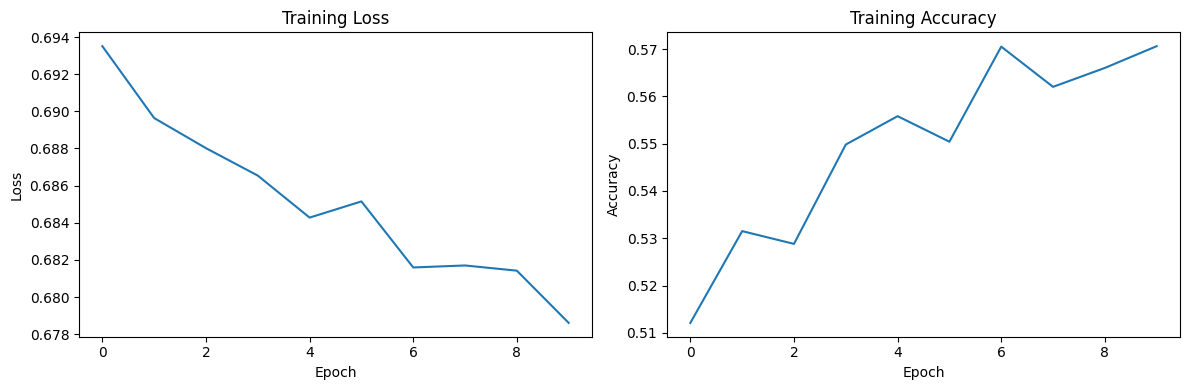

In [15]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the fully connected model on the test data
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5340


# part c)

In [17]:
# Define a custom ResNet model with a fully connected layer
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [19]:
# Initialize the model, criterion, and optimizer for both losses
model3 = CustomResNet(num_classes=2).to(device)
triplet_criterion = TripletLoss(margin=1.0)
cross_entropy_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)


In [20]:
# Training the model with both triplet and cross-entropy loss
num_epochs = 5
train_losses = []
train_accs = []

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader2:

        anchor, positive, negative, anchor_label = batch
        anchor, positive, negative, anchor_label = anchor.to(device), positive.to(device), negative.to(device), anchor_label.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs_anchor = model3(anchor)
        outputs_positive = model3(positive)
        outputs_negative = model3(negative)

        # Calculate losses
        loss_triplet = triplet_criterion(outputs_anchor, outputs_positive, outputs_negative)
        loss_cross_entropy = cross_entropy_criterion(outputs_anchor, anchor_label)
        loss_total = loss_triplet + loss_cross_entropy

        # Backward pass
        loss_total.backward()
        optimizer.step()

        running_loss += loss_total.item()

        _, predicted = torch.max(outputs_anchor.data, 1)
        total += anchor_label.size(0)
        correct += (predicted == anchor_label).sum().item()

    epoch_loss = running_loss / len(train_loader2)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/5, Loss: 1.5405, Accuracy: 0.7803
Epoch 2/5, Loss: 1.4608, Accuracy: 0.8156
Epoch 3/5, Loss: 1.4256, Accuracy: 0.8524
Epoch 4/5, Loss: 1.3819, Accuracy: 0.8715
Epoch 5/5, Loss: 1.3702, Accuracy: 0.8864


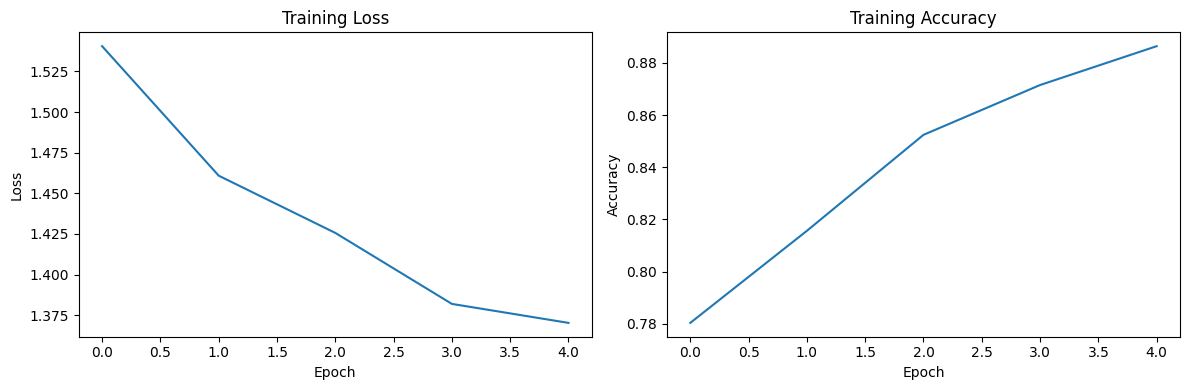

In [21]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [22]:
# Evaluate the model on the test data
model3.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8870
